In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import time
import mani_skill.env
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style


#####################  hyper parameters  ####################

MAX_EPISODES = 1500               # 最大训练代数
MAX_EP_STEPS = 200               # episode最大持续帧数

RENDER = False

LOAD_MEM = False
LOAD_MODEL = False
LOAD_FOLDER_NAME = 'carbinet_1000epi'

LOAD_PRETRAIN = False


ENV_NAME = 'OpenCabinetDrawer-v0'         # 游戏名称
SEED = 123                       # 随机数种子

var = 5
var_low_bound = 0.2

In [40]:
###############################  DDPG  ####################################
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,):
        self.a_dim = a_dim
        self.s_dim = s_dim
        self.a_bound = a_bound
        self.pointer = 0                                                                         # exp buffer指针
        self.lr_a = 0.001                                                                        # learning rate for actor
        self.lr_c = 0.001                                                                        # learning rate for critic
        self.gamma = 0.9                                                                         # reward discount
        self.tau = 0.0001                                                                          # 软更新比例
        self.memory_capacity = 20000
        self.batch_size = 32
        self.memory = np.zeros((self.memory_capacity, s_dim * 2 + a_dim + 1), dtype=np.float32)

        self.Reward_record = []
        
        class ANet(nn.Module):                               # 定义动作网络
            def __init__(self, s_dim, a_dim, a_bound):
                super(ANet,self).__init__()
                self.a_bound = a_bound
                self.fc1 = nn.Linear(s_dim,1024)
                self.fc1.weight.data.normal_(0,0.1)          # initialization
                
                self.fc2 = nn.Linear(1024,1024)
                self.fc2.weight.data.normal_(0,0.1)
                               
                self.fc3 = nn.Linear(1024,1024)
                self.fc3.weight.data.normal_(0,0.1)
                
                self.fc4 = nn.Linear(1024,1024)
                self.fc4.weight.data.normal_(0,0.1)
                
                self.out = nn.Linear(1024,a_dim)
                self.out.weight.data.normal_(0,0.1)          # initialization
            def forward(self,x):
                x = self.fc1(x)
                x = F.relu(x)
                
                x = self.fc2(x)
                x = F.relu(x)
                
                x = self.fc3(x)
                x = F.relu(x)
                
                x = self.fc4(x)
                x = F.relu(x)               
                
                x = self.out(x)
                x = F.tanh(x)
                actions_value = x * a_bound
                return actions_value

        class CNet(nn.Module):                               # 定义价值网络
            def __init__(self,s_dim,a_dim):
                super(CNet,self).__init__()
                self.fcs1 = nn.Linear(s_dim,1024)
                self.fcs1.weight.data.normal_(0,0.1)          # initialization
                #self.fcs1.weight.data.fill_(-0.01)
                
                self.fcs2 = nn.Linear(1024,1024)
                self.fcs2.weight.data.normal_(0,0.1)          # initialization
                #self.fcs1.weight.data.fill_(-0.01)
                
                self.fcs3 = nn.Linear(1024,1024)
                self.fcs3.weight.data.normal_(0,0.1)          # initialization
                #self.fcs1.weight.data.fill_(-0.01) 

                self.fcs4 = nn.Linear(1024,1024)
                self.fcs4.weight.data.normal_(0,0.1) 
                
                self.fca1 = nn.Linear(a_dim,1024)
                self.fca1.weight.data.normal_(0,0.1)          # initialization
                #self.fcs1.weight.data.fill_(-0.01)
                
                self.fca2 = nn.Linear(1024,1024)
                self.fca2.weight.data.normal_(0,0.1)          # initialization
                #self.fcs1.weight.data.fill_(-0.01)              
                
                self.fca3 = nn.Linear(1024,1024)
                self.fca3.weight.data.normal_(0,0.1)          # initialization
                #self.fcs1.weight.data.fill_(-0.01)
                
                self.fca4 = nn.Linear(1024,1024)
                self.fca4.weight.data.normal_(0,0.1)
                
                self.out = nn.Linear(1024,1)
                self.out.weight.data.normal_(0,0.1)          # initialization
                #self.fcs1.weight.data.fill_(-0.01)
            def forward(self,s,a):
                x = self.fcs1(s)                              # 输入状态
                x = F.relu(x)
                
                x = self.fcs2(x)
                x = F.relu(x)
                
                x = self.fcs3(x)
                x = F.relu(x)
                
                x = self.fcs4(x)
                x = F.relu(x)
                
                y = self.fca1(a)                              # 输入动作
                y = F.relu(y)
                
                y = self.fca2(y)                              
                y = F.relu(y)
                
                y = self.fca3(y)                              
                y = F.relu(y)
                
                y = self.fca4(y)                              
                y = F.relu(y)
                
                net = F.relu(x+y)
                actions_value = self.out(net)                # 给出V(s,a)
                return actions_value

        self.Actor_eval = ANet(s_dim, a_dim, a_bound)        # 主网络
        self.Actor_target = ANet(s_dim, a_dim, a_bound)      # 目标网络
        self.Critic_eval = CNet(s_dim, a_dim)                # 主网络
        self.Critic_target = CNet(s_dim, a_dim)              # 当前网络
        self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr = self.lr_c) # critic的优化器
        self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr = self.lr_a)  # actor的优化器
        self.loss_td = nn.MSELoss()                          # 损失函数采用均方误差

    def choose_action(self, s):
        s = torch.unsqueeze(torch.FloatTensor(s), 0)
        #print('choose action: ',self.Actor_eval(s))
        #print('choose action 0 : ', self.Actor_eval(s)[0])
        #print('forward: ',self.Actor_eval.forward(s))
        return self.Actor_eval(s)[0].detach()                # detach()不需要计算梯度 #用forward等价（应该

    def learn(self):

        for x in self.Actor_target.state_dict().keys():#更新target network
            eval('self.Actor_target.' + x + '.data.mul_((1 - self.tau))')  
            eval('self.Actor_target.' + x + '.data.add_(self.tau * self.Actor_eval.' + x + '.data)')
        for x in self.Critic_target.state_dict().keys():
            eval('self.Critic_target.' + x + '.data.mul_((1- self.tau))')
            eval('self.Critic_target.' + x + '.data.add_(self.tau * self.Critic_eval.' + x + '.data)')

        # soft target replacement

        indices = np.random.choice(self.memory_capacity, size = self.batch_size)  # 随机采样的index
        bt = self.memory[indices, :]                                              # 采样batch_size个sample
        bs = torch.FloatTensor(bt[:, :self.s_dim])                                # state
        ba = torch.FloatTensor(bt[:, self.s_dim: self.s_dim + self.a_dim])        # action
        br = torch.FloatTensor(bt[:, -self.s_dim - 1: -self.s_dim])               # reward
        bs_ = torch.FloatTensor(bt[:, -self.s_dim:])                              # next state
        
        
        a = self.Actor_eval(bs)
        q = self.Critic_eval(bs,a)  # 依据critic给出的打分 来更新actor 使得actor作出的预测才critic这边能得到更高的分数
                                    # 如果 a是一个正确的行为的话，那么它的Q应该更贴近0
        loss_a = -torch.mean(q)     #一个batch输入进去，有好多个q所以要做平均
        #print('q: ',q)
        #print('loss_a: ',loss_a)
        self.atrain.zero_grad()
        loss_a.backward()
        self.atrain.step()
        
        
        a_ = self.Actor_target(bs_)      # 预测下一步会做什么动作
        q_ = self.Critic_target(bs_,a_)  # 给预测出的下一步动作进行打分-- 用于给出 Actor 更新参数时的 Gradient ascent 强度
        q_target = br + self.gamma * q_  # 
        #print('q_target: ', q_target)
        #print('Reward: ', br)
        #print('q_: ', q_)
        q_v = self.Critic_eval(bs,ba)    # 对这一步的动作进行打分 
        #print('q_v: ', q_v)
        td_error = self.loss_td(q_target,q_v)
        # td_error = R + self.gamma * ct（bs_,at(bs_)）-ce(s,ba) 更新ce ,但这个ae(s)是记忆中的ba，让ce得出的Q靠近Q_target,让评价更准确
        # print('td error: ', torch.mean(td_error))
        self.ctrain.zero_grad()
        td_error.backward()
        self.ctrain.step()
        
        
    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % self.memory_capacity     # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1                               # 指示sample位置的指针+1
    
    def store_reward(self,ep_reward):
        self.Reward_record.append(ep_reward)
        
    def save(self,folder_name):
    
        os.mkdir('./DPG model/' + folder_name)
    
        PATH1 = './DPG model/' + folder_name + '/Actor_eval.h5f'
        PATH2 = './DPG model/' + folder_name + '/Actor_target.h5f'
        PATH3 = './DPG model/' + folder_name + '/Critic_eval.h5f'
        PATH4 = './DPG model/' + folder_name + '/Critic_target.h5f'
    
        torch.save(self.Actor_eval.state_dict(), PATH1)
        torch.save(self.Actor_target.state_dict(), PATH2)
        torch.save(self.Critic_eval.state_dict(), PATH3)
        torch.save(self.Critic_target.state_dict(), PATH4)
    
        csv_name='./DPG model/' + folder_name + '/memory.csv'
        xml_df = pd.DataFrame(self.memory)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Rewards.csv'
        xml_df = pd.DataFrame(self.Reward_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        plt.scatter(x, y)
        plt.savefig('./DPG model/' + folder_name + '/scatter.png')
        plt.plot(x, y)
        plt.savefig('./DPG model/' + folder_name + '/plot.png')
        
    def plot_file_rewards(self, folder_name):
        data = pd.read_csv('./DPG model/' + folder_name + '/Rewards.csv')
        y = np.array(data).squeeze()
        x = range(y.shape[0])
        plt.figure(figsize=(10, 10), dpi=70)
        #plt.plot(x, y)
        plt.scatter(x, y)
        plt.show()
    
    def plot_rewards(self, scatter):
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
            
        if scatter:
            plt.scatter(x, y)
        else:
            plt.plot(x, y)
        plt.show()
    
    def load_model(self):
        self.Actor_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_eval.h5f'))
        self.Actor_eval.eval()
        self.Actor_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_target.h5f'))
        self.Actor_target.eval()
        self.Critic_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_eval.h5f'))
        self.Critic_eval.eval()
        self.Critic_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_target.h5f'))
        self.Critic_target.eval()
        print("Load network parameters of: " + LOAD_FOLDER_NAME) 
        
    def load_memory(self):
        data = pd.read_csv('./DPG model/' + LOAD_FOLDER_NAME + '/memory.csv')
        self.memory = np.array(data)
        print("Load memory of: " + LOAD_FOLDER_NAME)
    
    def load_pretrain(self):
        self.Actor_eval.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        self.Actor_eval.eval()
        self.Actor_target.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        self.Actor_target.eval()        
        print("Load pretrained actor")

In [41]:
###############################  training  ####################################
env = gym.make(ENV_NAME)
env = env.unwrapped
env.seed(SEED)                                          # 设置Gym的随机数种子
torch.manual_seed(SEED)                                 # 设置pytorch的随机数种子

env.set_env_mode(obs_mode='state', reward_type='dense')

s_dim = env.observation_space.shape[0]                  # 状态空间
a_dim = env.action_space.shape[0]                       # 动作空间
a_bound = 1                         # 动作取值区间,对称区间，故只取上界
ddpg = DDPG(a_dim, s_dim, a_bound)

if LOAD_MODEL:
    ddpg.load_model()
    
if LOAD_MEM:
    ddpg.load_memory()

if LOAD_PRETRAIN:
    ddpg.load_pretrain()

if LOAD_MODEL or LOAD_MEM:
    var = 0.5

if LOAD_PRETRAIN:
    var = 0.1
    
t1 = time.time()                                        # 开始时间

for i in range(MAX_EPISODES):
    s = env.reset(level = 1)
    ep_reward = 0

    for j in range(MAX_EP_STEPS):
        if RENDER:
            env.render('human')

        # Add exploration noise
        a = ddpg.choose_action(s)

        a = np.clip(np.random.normal(a, var), -1, 1)    # add randomness to action selection for exploration

        s_, r, done, info = env.step(a)
        
        info_ = info.get('eval_info')
        
        if info_.get('success'):
            print('SUCCESS')
            r += 10000
        
        r += 10
        r = r * 4
        ddpg.store_transition(s, a, r , s_)         # 为什么要对reward归一化

        if ddpg.pointer > ddpg.memory_capacity or LOAD_MEM:         # 经验池已满
            if var > var_low_bound:
                var *= .9998                            # 学习阶段逐渐降低动作随机性decay the action randomness
            ddpg.learn()                                # 开始学习

        s = s_
        ep_reward += r
        if j == MAX_EP_STEPS-1 or done:
            print('Episode:', i, ' Reward: %i' % int(ep_reward), 'Explore: %.2f' % var, )
            
            ddpg.store_reward(ep_reward)
            
            if ep_reward > -100 or i == (MAX_EPISODES - 5):
                RENDER = True
            
            break
               
print('Running time: ', time.time() - t1)

Episode: 0  Reward: -4025 Explore: 5.00
Episode: 1  Reward: -2809 Explore: 5.00
Episode: 2  Reward: -2103 Explore: 5.00
Episode: 3  Reward: -3210 Explore: 5.00
Episode: 4  Reward: -2167 Explore: 5.00
Episode: 5  Reward: -3016 Explore: 5.00
Episode: 6  Reward: -2612 Explore: 5.00
Episode: 7  Reward: -2170 Explore: 5.00
Episode: 8  Reward: -3134 Explore: 5.00
Episode: 9  Reward: -2848 Explore: 5.00
Episode: 10  Reward: -3490 Explore: 5.00
Episode: 11  Reward: -2446 Explore: 5.00
Episode: 12  Reward: -2218 Explore: 5.00
Episode: 13  Reward: -2218 Explore: 5.00
Episode: 14  Reward: -3160 Explore: 5.00
Episode: 15  Reward: -3310 Explore: 5.00
Episode: 16  Reward: -3151 Explore: 5.00
Episode: 17  Reward: -3305 Explore: 5.00
Episode: 18  Reward: -2171 Explore: 5.00
Episode: 19  Reward: -2027 Explore: 5.00
Episode: 20  Reward: -2569 Explore: 5.00
Episode: 21  Reward: -3600 Explore: 5.00
Episode: 22  Reward: -2145 Explore: 5.00
Episode: 23  Reward: -2599 Explore: 5.00
Episode: 24  Reward: -2146

Episode: 198  Reward: -3006 Explore: 0.20
Episode: 199  Reward: -3124 Explore: 0.20
Episode: 200  Reward: -3094 Explore: 0.20
Episode: 201  Reward: -3053 Explore: 0.20
Episode: 202  Reward: -3093 Explore: 0.20
Episode: 203  Reward: -3107 Explore: 0.20
Episode: 204  Reward: -3112 Explore: 0.20
Episode: 205  Reward: -3112 Explore: 0.20
Episode: 206  Reward: -3034 Explore: 0.20
Episode: 207  Reward: -3082 Explore: 0.20
Episode: 208  Reward: -3115 Explore: 0.20
Episode: 209  Reward: -2991 Explore: 0.20
Episode: 210  Reward: -3109 Explore: 0.20
Episode: 211  Reward: -3014 Explore: 0.20
Episode: 212  Reward: -3060 Explore: 0.20
Episode: 213  Reward: -3099 Explore: 0.20
Episode: 214  Reward: -3021 Explore: 0.20
Episode: 215  Reward: -3087 Explore: 0.20
Episode: 216  Reward: -3121 Explore: 0.20
Episode: 217  Reward: -3047 Explore: 0.20
Episode: 218  Reward: -3076 Explore: 0.20
Episode: 219  Reward: -3061 Explore: 0.20
Episode: 220  Reward: -3052 Explore: 0.20
Episode: 221  Reward: -3085 Explor

Episode: 394  Reward: -3114 Explore: 0.20
Episode: 395  Reward: -3077 Explore: 0.20
Episode: 396  Reward: -3026 Explore: 0.20
Episode: 397  Reward: -3004 Explore: 0.20
Episode: 398  Reward: -3088 Explore: 0.20
Episode: 399  Reward: -3120 Explore: 0.20
Episode: 400  Reward: -3048 Explore: 0.20
Episode: 401  Reward: -2982 Explore: 0.20
Episode: 402  Reward: -3045 Explore: 0.20
Episode: 403  Reward: -3117 Explore: 0.20
Episode: 404  Reward: -3155 Explore: 0.20
Episode: 405  Reward: -3008 Explore: 0.20
Episode: 406  Reward: -3059 Explore: 0.20
Episode: 407  Reward: -3035 Explore: 0.20
Episode: 408  Reward: -3138 Explore: 0.20
Episode: 409  Reward: -3114 Explore: 0.20
Episode: 410  Reward: -3051 Explore: 0.20
Episode: 411  Reward: -3137 Explore: 0.20
Episode: 412  Reward: -3091 Explore: 0.20
Episode: 413  Reward: -3168 Explore: 0.20
Episode: 414  Reward: -3079 Explore: 0.20
Episode: 415  Reward: -3063 Explore: 0.20
Episode: 416  Reward: -3026 Explore: 0.20
Episode: 417  Reward: -3118 Explor

Episode: 590  Reward: -3083 Explore: 0.20
Episode: 591  Reward: -3080 Explore: 0.20
Episode: 592  Reward: -3124 Explore: 0.20
Episode: 593  Reward: -3168 Explore: 0.20
Episode: 594  Reward: -3089 Explore: 0.20
Episode: 595  Reward: -3023 Explore: 0.20
Episode: 596  Reward: -3141 Explore: 0.20
Episode: 597  Reward: -3058 Explore: 0.20
Episode: 598  Reward: -3061 Explore: 0.20
Episode: 599  Reward: -3056 Explore: 0.20
Episode: 600  Reward: -3069 Explore: 0.20
Episode: 601  Reward: -3034 Explore: 0.20
Episode: 602  Reward: -3081 Explore: 0.20
Episode: 603  Reward: -3113 Explore: 0.20
Episode: 604  Reward: -3148 Explore: 0.20
Episode: 605  Reward: -3082 Explore: 0.20
Episode: 606  Reward: -3002 Explore: 0.20
Episode: 607  Reward: -3069 Explore: 0.20
Episode: 608  Reward: -3099 Explore: 0.20
Episode: 609  Reward: -3028 Explore: 0.20
Episode: 610  Reward: -3121 Explore: 0.20
Episode: 611  Reward: -3040 Explore: 0.20
Episode: 612  Reward: -3073 Explore: 0.20
Episode: 613  Reward: -2976 Explor

Episode: 786  Reward: -3092 Explore: 0.20
Episode: 787  Reward: -3160 Explore: 0.20
Episode: 788  Reward: -3086 Explore: 0.20
Episode: 789  Reward: -3039 Explore: 0.20
Episode: 790  Reward: -3090 Explore: 0.20
Episode: 791  Reward: -3052 Explore: 0.20
Episode: 792  Reward: -3016 Explore: 0.20
Episode: 793  Reward: -3185 Explore: 0.20
Episode: 794  Reward: -3089 Explore: 0.20
Episode: 795  Reward: -2981 Explore: 0.20
Episode: 796  Reward: -3072 Explore: 0.20
Episode: 797  Reward: -3064 Explore: 0.20
Episode: 798  Reward: -3049 Explore: 0.20
Episode: 799  Reward: -2993 Explore: 0.20
Episode: 800  Reward: -3041 Explore: 0.20
Episode: 801  Reward: -3097 Explore: 0.20
Episode: 802  Reward: -3141 Explore: 0.20
Episode: 803  Reward: -3125 Explore: 0.20
Episode: 804  Reward: -3024 Explore: 0.20
Episode: 805  Reward: -3049 Explore: 0.20
Episode: 806  Reward: -3130 Explore: 0.20
Episode: 807  Reward: -3018 Explore: 0.20
Episode: 808  Reward: -3018 Explore: 0.20
Episode: 809  Reward: -3137 Explor

Episode: 982  Reward: -3073 Explore: 0.20
Episode: 983  Reward: -3118 Explore: 0.20
Episode: 984  Reward: -3140 Explore: 0.20
Episode: 985  Reward: -3070 Explore: 0.20
Episode: 986  Reward: -3060 Explore: 0.20
Episode: 987  Reward: -3191 Explore: 0.20
Episode: 988  Reward: -3117 Explore: 0.20
Episode: 989  Reward: -3073 Explore: 0.20
Episode: 990  Reward: -3064 Explore: 0.20
Episode: 991  Reward: -3078 Explore: 0.20
Episode: 992  Reward: -3027 Explore: 0.20
Episode: 993  Reward: -3034 Explore: 0.20
Episode: 994  Reward: -3123 Explore: 0.20
Episode: 995  Reward: -3061 Explore: 0.20
Episode: 996  Reward: -3084 Explore: 0.20
Episode: 997  Reward: -3152 Explore: 0.20
Episode: 998  Reward: -3001 Explore: 0.20
Episode: 999  Reward: -3147 Explore: 0.20
Episode: 1000  Reward: -3136 Explore: 0.20
Episode: 1001  Reward: -3085 Explore: 0.20
Episode: 1002  Reward: -3106 Explore: 0.20
Episode: 1003  Reward: -3080 Explore: 0.20
Episode: 1004  Reward: -3026 Explore: 0.20
Episode: 1005  Reward: -3087 

Episode: 1173  Reward: -3161 Explore: 0.20
Episode: 1174  Reward: -3042 Explore: 0.20
Episode: 1175  Reward: -3098 Explore: 0.20
Episode: 1176  Reward: -3060 Explore: 0.20
Episode: 1177  Reward: -3108 Explore: 0.20
Episode: 1178  Reward: -3048 Explore: 0.20
Episode: 1179  Reward: -3034 Explore: 0.20
Episode: 1180  Reward: -2951 Explore: 0.20
Episode: 1181  Reward: -3091 Explore: 0.20
Episode: 1182  Reward: -3092 Explore: 0.20
Episode: 1183  Reward: -3047 Explore: 0.20
Episode: 1184  Reward: -3038 Explore: 0.20
Episode: 1185  Reward: -3070 Explore: 0.20
Episode: 1186  Reward: -3069 Explore: 0.20
Episode: 1187  Reward: -3100 Explore: 0.20
Episode: 1188  Reward: -3095 Explore: 0.20
Episode: 1189  Reward: -3184 Explore: 0.20
Episode: 1190  Reward: -2979 Explore: 0.20
Episode: 1191  Reward: -3058 Explore: 0.20
Episode: 1192  Reward: -3113 Explore: 0.20
Episode: 1193  Reward: -3080 Explore: 0.20
Episode: 1194  Reward: -3111 Explore: 0.20
Episode: 1195  Reward: -3113 Explore: 0.20
Episode: 11

KeyboardInterrupt: 

In [22]:
ddpg.save('carbinet_1000epi_four1024layers')

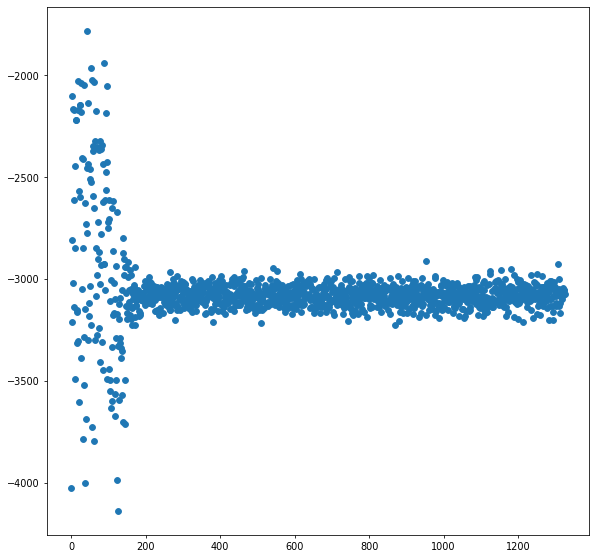

In [42]:
ddpg.plot_rewards(scatter = True)

In [7]:
info

{'eval_info': {'cabinet_static': True, 'open_enough': False, 'success': False},
 'dist_ee_to_handle': array([1.32828861, 1.30526796]),
 'angle1': 1.1766494349134005,
 'angle2': 1.5317321746066244,
 'dist_ee_mid_to_handle': -1.3160184768477239,
 'rew_ee_handle': -2.6335565692093796,
 'rew_ee_mid_handle': -1.0,
 'qpos_rew': 0,
 'qvel_rew': 0,
 'gripper_angle_err': 67.4170465869911,
 'gripper_angle_rew': -1.1236174431165185,
 'gripper_vel_norm': 0.0,
 'gripper_ang_vel_norm': 0.0,
 'qpos': 0.0,
 'qvel': 0.0,
 'target_qpos': 0.23135713040828706,
 'reward_raw': -6.757174012325898,
 'stage_reward': -7.0,
 'TimeLimit.truncated': True}

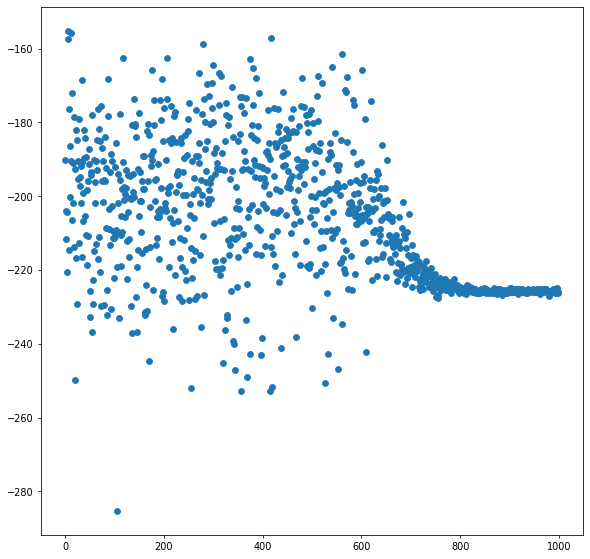

In [20]:
y = ddpg.Reward_record
x = range(len(y))
plt.figure(figsize=(10, 10), dpi=70)
        
plt.scatter(x, y)
#plt.plot(x, y)
plt.savefig('./scatter.png')
#plt.show()